In [ ]:
# !pip install segmentation-models-pytorch

In [4]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import segmentation_models_pytorch as smp
import albumentations
import albumentations.pytorch

import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
pl.seed_everything(42, workers=True)

Seed set to 42


42

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


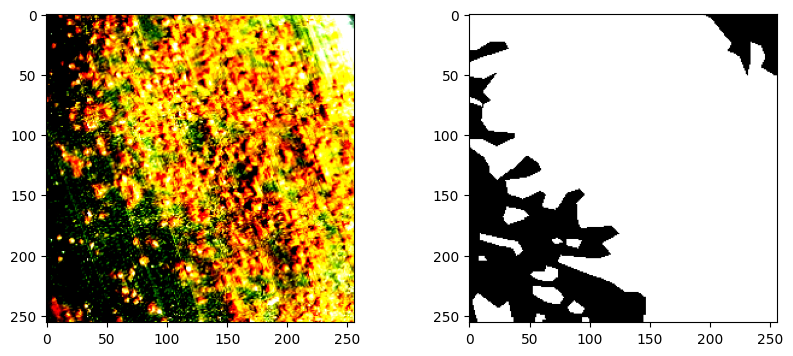

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_filenames, image_dir, mask_dir=None, image_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.image_paths = []
        self.mask_paths = []

        for filename in image_filenames:
            image_path = os.path.join(image_dir, filename)
            self.image_paths.append(image_path)
            if self.mask_dir:
                self.mask_paths.append(os.path.join(mask_dir, filename.replace('.jpg', '.png')))
            # for local test
            # if (len(self.image_paths) == 10):
            #     break

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape
        # image = np.array(image).astype(np.float32)

        if self.mask_dir:
            mask = cv2.imread(self.mask_paths[idx])
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            # _, mask = cv2.threshold(mask, 1, 1, cv2.THRESH_BINARY)
            mask[mask > 0.0] = 1.0
            # mask = np.array(mask).astype(np.float32)

            transformed = self.image_transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = np.expand_dims(mask, 0)

            return image, mask
        else:
            transformed = self.image_transform(image=image)
            image = transformed["image"]
            id = os.path.basename(self.image_paths[idx]).split('.')[0]
            return image, id, torch.tensor((h, w))

train_transform = albumentations.Compose([
    albumentations.RandomResizedCrop(256, 256),
    albumentations.OneOf([
        albumentations.HorizontalFlip(p=1),
        albumentations.VerticalFlip(p=1),
        albumentations.RandomRotate90(p=1),
    ], p=0.75),
    albumentations.RandomBrightnessContrast(),
    albumentations.Normalize(),
    albumentations.pytorch.ToTensorV2(),
])

test_transform = albumentations.Compose([
    albumentations.Resize(256, 256),
    albumentations.Normalize(),
    albumentations.pytorch.ToTensorV2()
])

data_path = "/kaggle/input/kau-semantic-segmentation-leaf-disease/"
train_images_path = os.path.join(data_path, 'train/images/')
train_masks_path  = os.path.join(data_path, 'train/masks/')
test_images_path  = os.path.join(data_path, 'test/images/')
train_imgs, valid_imgs = train_test_split(os.listdir(train_images_path), test_size=0.2, random_state=42)
test_imgs = os.listdir(test_images_path)

train_dataset = CustomDataset(train_imgs, train_images_path, train_masks_path, image_transform=train_transform)
valid_dataset = CustomDataset(valid_imgs, train_images_path, train_masks_path, image_transform=train_transform)
test_dataset  = CustomDataset(test_imgs,  test_images_path,                    image_transform=test_transform)

BS = 64
train_data_loader = DataLoader(train_dataset, shuffle=True,  num_workers=2, batch_size=BS)
valid_data_loader = DataLoader(valid_dataset, shuffle=False, num_workers=2, batch_size=BS)
test_data_loader  = DataLoader(test_dataset,  shuffle=False, num_workers=1, batch_size=1)

img, mask = next(iter(train_data_loader))
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(img[0].permute(1, 2, 0)) # convert (3, 256, 256) -> (256, 256, 3)
plt.subplot(122)
plt.imshow(mask[0].permute(1, 2, 0), cmap='gray')

In [3]:
class BinarySegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # # kaggle score = 0.66
        # self.model = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
        # self.model.classifier[-1] = torch.nn.Conv2d(512, 1, kernel_size=1)
        # self.model.aux_classifier = None

        # kaggle score = 0.73
        self.model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        self.model.classifier[-1] = torch.nn.Conv2d(256, 1, kernel_size=1)
        # TODO try use this thing
        self.model.aux_classifier = None

        self.loss = smp.losses.DiceLoss('binary')
        self.running_loss_train = []
        self.running_loss_valid = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        out = self.model(images)['out']
        loss = self.loss(out, masks)
        self.log("train_loss", loss, on_step=True, prog_bar=True)
        self.running_loss_train.append(loss)
        return loss

    def on_train_epoch_end(self):
        avg_loss = sum(self.running_loss_train) / len(self.running_loss_train)
        self.log("epoch_train_loss", avg_loss, on_epoch=True, prog_bar=True, sync_dist=True)
        self.running_loss_train.clear()
        return avg_loss
    
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        out = self.model(images)['out']
        loss = self.loss(out, masks)
        self.running_loss_valid.append(loss)
        return loss

    def on_validation_epoch_end(self):
        avg_loss = sum(self.running_loss_valid) / len(self.running_loss_valid)
        self.log("epoch_val_loss", avg_loss, on_epoch=True, prog_bar=True, sync_dist=True)
        self.running_loss_valid.clear()
        return avg_loss

    def predict_step(self, batch, batch_idx):
        img, id, original_shape = batch
        mask = model(img)['out']
        mask = mask[0].permute(1, 2, 0)
        id = id[0]
        original_shape= original_shape[0]
        mask = (mask.cpu().numpy() > 0.5).astype(np.uint8)
        w, h = original_shape.cpu().numpy()
        mask = cv2.resize(mask, (h, w), interpolation=cv2.INTER_NEAREST)
#         mask = np.squeeze(mask, axis=2)
        mask = mask.flatten()
        return(f"{id},{binary_mask_to_rle(mask)}")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-6, factor=0.1, verbose=True)
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "epoch_val_loss"
        }
        return optimizer

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="/kaggle/working/runs/", 
    filename='{epoch}-{epoch_val_loss:.3f}-{epoch_train_loss:.3f}',
    monitor='epoch_val_loss',
    mode='min',        
    save_top_k=5,
    verbose=True)

trainer = pl.Trainer(
    max_epochs=50,
    devices=2,
    strategy="ddp_notebook",
    accelerator="gpu",
    precision="16-mixed",
    callbacks=[checkpoint_callback],
)

# model = BinarySegmentation()
model = BinarySegmentation.load_from_checkpoint(
    checkpoint_path='/kaggle/input/leafsegmentationckpt/12-epoch_val_loss_dice0.208-epoch_train_loss_dice0.158.ckpt',
    map_location="cpu"
)
# model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/data/osamoile/cv/image-processing-braille-olehsamoilenko/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


BinarySegmentation(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
trainer.fit(model=model, train_dataloaders=train_data_loader, val_dataloaders=valid_data_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2765)
14,44 1 375 0 44 1 375 0 44 1 375 0 44 1 375 0 47 1 372 0 52 1 367 0 56 1 363 0 59 1 5 0 3 1 352 0 68 1 351 0 69 1 350 0 70 1 311 0 4 1 34 0 70 1 310 0 7 1 32 0 71 1 308 0 8 1 32 0 71 1 308 0 7 1 33 0 72 1 264 0 1 1 43 0 6 1 33 0 73 1 263 0 2 1 42 0 5 1 34 0 73 1 262 0 4 1 41 0 5 1 34 0 74 1 261 0 7 1 38 0 4 1 35 0 74 1 261 0 9 1 37 0 3 1 35 0 75 1 260 0 11 1 36 0 2 1 35 0 75 1 259 0 14 1 19 0 2 1 11 0 4 1 35 0 75 1 258 0 18 1 16 0 4 1 7 0 7 1 34 0 75 1 257 0 20 1 15 0 5 1 5 0 9 1 33 0 75 1 257 0 21 1 13 0 7 1 4 0 9 1 33 0 74 1 257 0 23 1 12 0 8 1 2 0 11 1 32 0 74 1 256 0 25 1 10 0 9 1 2 0 12 1 11 0 1 1 19 0 74 1 256 0 26 1 9 0 10 1 1 0 12 1 9 0 5 1 17 0 74 1 255 0 28 1 7 0 11 1 1 0 13 1 7 0 97 1 255 0 28 1 7 0 10 1 2 0 13 1 8 0 9 1 5 0 82 1 255 0 28 1 7 0 9 1 4 0 12 1 8 0 6 1 16 0 73 1 256 0 28 1 7 0 9 1 4 0 11 1 10 0 3 1 18 0 73 1 256 0 27 1 8 0 9 1 5 0 10 1 11 0 1 1 19 0 73 1 256 0 27 1 8 0 8 1 6 0 10 1 31 0 72 1 256 0 28 1 8 0 8 1 7 0 8 1 32 0 72 1 256 0 28 1 8 0 8 1

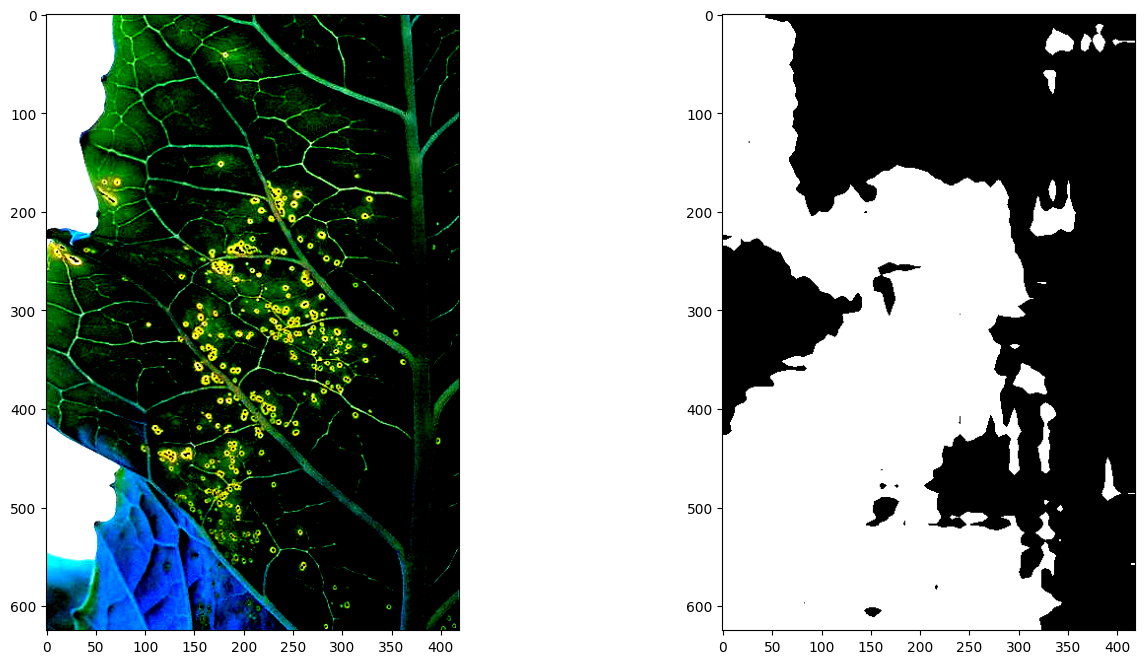

In [40]:
def binary_mask_to_rle(binary_mask):
    rle = []
    current_pixel = binary_mask[0]
    run_length = 1

    for pixel in binary_mask[1:]:
        if pixel == current_pixel:
            run_length += 1
        else:
            rle.append(run_length)
            rle.append(current_pixel)
            current_pixel = pixel
            run_length = 1

    # Append the last run
    rle.append(run_length)
    rle.append(current_pixel)
    converted_list = map(str, rle)
    return ' '.join(converted_list)

img, id, original_shape = next(iter(test_data_loader))
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(img[0].permute(1, 2, 0))

print(original_shape[0].numpy())
print(id[0])
img[0].shape

with torch.no_grad():
    model.eval()
    mask = model(img)['out']
    mask = mask[0]
    id = id[0]
    original_shape= original_shape[0]

    mask = mask.permute(1, 2, 0)
    mask = (mask.numpy() > 0.5).astype(np.uint8)
    plt.subplot(132)
    plt.imshow(mask, cmap='gray')

    w, h = original_shape.numpy()
    mask = cv2.resize(mask, (h, w), interpolation=cv2.INTER_NEAREST)
    plt.subplot(133)
    plt.imshow(mask, cmap='gray')

#     mask = np.squeeze(mask, axis=2)
    mask = mask.flatten()
    print(f"{id},{binary_mask_to_rle(mask)}")

In [36]:
trainer = pl.Trainer()
res = trainer.predict(model, test_data_loader)
out = '/kaggle/working/runs/res.csv'
with open(out, 'w') as f:
    f.write('id,mask_string\n')
    for line in res:
        f.write(line)
        f.write('\n')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/media/data/osamoile/cv/image-processing-braille-olehsamoilenko/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]
